<h1>RQ1 -What are the characteristics of in-range updates that break a client’s build?</h1>

<h2>Motivation</h2>
<p>
It is not uncommon for client packages to specify a range of versions they would like to accept from a provider package, as using versioning range statements has the advantage of reducing the overhead of keeping its provider up-to-date (Cogo et al., 2019). However, the adoption of version range statements leaves the client package susceptible to implicitly accepting a dependency release that makes the provider package no longer compatible with their own. When this scenario occurs, not only will the client’s build be broken, but also any additional packages that depend on them will also be affected. Therefore, build issues caused by a dependency specified with a version range should be treated with a sense of urgency in order to get them resolved as quickly as possible. While numerous studies have investigated breaking changes (refs), none have looked specifically at issues caused by in-range updates. Identifying characteristics of in-range breaking changes can provide insight to provider package maintainers to help them avoid inadvertently releasing changes that could potentially have a high impact on clients who use a version range for their dependency. Additionally, while multiple studies suggest that practitioners often advocate against the adoption of version range statements due to the possibility of being caught by a surprised breaking provider release, doing so is identified to be a dependency code smell (Jafari et al., 2020). Investigating these in-range breakages could provide insight into which type of version range specification is safest, and which should be avoided. Therefore, in this RQ, we investigate what types of changes are released by providers that are automatically accepted by clients but end up breaking the client's build.  
</p>

<h2>Findings</h2>
<ul>
    <li><b>Finding) The majority of in-range breaking updates are caused by development dependencies.</b></li>
</ul>

<h3>Load helper functions</h3>

In [152]:
%run _utils.ipynb

<h3>Load data set</h3>

In [85]:
issues = load_issues()
client_packages = load_package_names()
library_versions = load_library_versions()

<h3><i>What dependency types are causeing in-range breakages in their clients?</i></h3>

In [67]:
proportions = (
    issues['dependency_type'].value_counts() / 
    issues['dependency_type'].count()
).to_frame(name='proportion')\
    .rename_axis('dependency_type')\
    .reset_index()
proportions.head()

,dependency_type,proportion
0,devDependency,0.703926
1,dependency,0.294407
2,optionalDependency,0.000972
3,peerDependency,0.000695


<h3><i>What types of updates do dependencies release most often?</i></h3>

In [79]:
proportions = (
    library_versions['version_release_type'].value_counts() / 
    library_versions['version_release_type'].count()
).to_frame(name='proportion')\
    .rename_axis('release_type')\
    .reset_index()
proportions.head()

,release_type,proportion
0,PATCH,0.682885
1,MINOR,0.233746
2,MAJOR,0.083370


<h3><i>What dependency release types are causing in-range breakages in their clients?</i></h3>

In [71]:
issues_with_update_type = issues[~pd.isna(issues['update_type'])]
proportions = (
    issues_with_update_type['update_type'].value_counts() / 
    issues_with_update_type['update_type'].count()
).to_frame(name='proportion')\
    .rename_axis('release_type')\
    .reset_index()
proportions.head()

,release_type,proportion
0,PATCH,0.652902
1,MINOR,0.345551
2,MAJOR,0.001546


<h3><i>[Normalized] - What dependency release types are causing in-range breakages in their clients?</i></h3>

In [80]:
# TODO

<h4>How many dependencies do clients have?</h4>

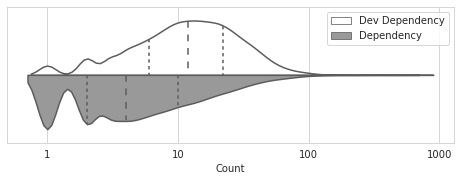

In [168]:
dependencies_count = dependencies\
    .groupby(('package'))['deps_type']\
    .value_counts()\
    .to_frame(name='count')\
    .reset_index()
dependencies_count['placeholder'] = ''
dependencies_count['count_log'] = np.log10(dependencies_count['count'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,2.5))
ax = sns.violinplot(
    data=dependencies_count,
    x='count_log',
    y='placeholder',
    hue='deps_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    scale='width',
)

ax.set_ylabel('')
ax.set_xlabel('Count')
ax.set_xticks([0, 1, 2, 3])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(10 ** x)))
ax.legend(
    title='',
    loc=1
)

plt.show()

<h3><i>What types of updates do clients accept (i.e. dependency version range)</i></h3>

In [130]:
# Parse and flatten each clients dependencies

import json

deps_dtos = list()

def parse_client_package_deps(row):
    deps_str = row['dependencies']
    if pd.isna(deps_str):
        deps = dict()
    else:
        deps = json.loads(deps_str.replace("'", '"')) if ~pd.isna(deps_str) else dict()
    dev_deps_str = row['dev_dependencies']
    if pd.isna(dev_deps_str):
        dev_deps = dict()
    else:
        dev_deps = json.loads(dev_deps_str.replace("'", '"')) if dev_deps_str else dict()
    deps_dtos.append({
        'package_name': row['name'],
        'deps': deps,
        'dev_deps': dev_deps,
    })

client_packages.apply(parse_client_package_deps, axis=1)
DEP = 'Dependency'
DEV_DEP = 'Dev Dependency'
packages = list()
deps_names = list()
deps_versions = list()
deps_types =  list()

for deps_dto in deps_dtos:
    package = deps_dto['package_name']
    for dep_name, dep_version in deps_dto['deps'].items():
        packages.append(package)
        deps_names.append(dep_name)
        deps_versions.append(dep_version)
        deps_types.append(DEP)
    for dep_name, dep_version in deps_dto['dev_deps'].items():
        packages.append(package)
        deps_names.append(dep_name)
        deps_versions.append(dep_version)
        deps_types.append(DEV_DEP)
        
dependencies = pd.DataFrame({
    'package': packages,
    'deps_name': deps_names,
    'deps_version': deps_versions,
    'deps_type': deps_types,
})

# For testing regex
# 13.4.9
# 10.1.1
# 0.1.92
# 16.13.1
# 1.0.1-RC.1
# 1.0.0-beta.30
# <2.0.0
# < 2.0.0
# ^0.0.1


# ~13.2.4
# 13.2.x
# 13.2.*
# 2.3
# ^0.1.2

# ^13.2.4
# 13.x
# 13.*
# 2.*.*
# 2
# 2

# *
# x
# >=20.0.0
# latest

regex_pinned = '^([<=]?\d+.\d+.\d+)|(^\^0.0.\d+$)'
regex_patch_release = '(^=?(\~|\d+.\d+.[x*]$)|^\d+.\d+$)|(^\^0.[1-9]\d*)'
regex_minor_release = '^=?(\^|\d+.([x*].)*[x*]$)|^\d+$'
regex_major_release = '^[\*x]$|^latest$|^>=|x.x|x.x.x'
dependencies_df['accepted_update_type'] = 'Unknown'

import warnings
warnings.filterwarnings('ignore', 'This pattern has match groups')

def set_accepted_update_type(df, reg_ex, accepted_update_type):
    df.loc[
        df['deps_version'].str.contains(reg_ex, regex=True),
        'accepted_update_type'
    ] = accepted_update_type

    
set_accepted_update_type(dependencies_df, regex_patch_release, PATCH)
set_accepted_update_type(dependencies_df, regex_minor_release, MINOR)
set_accepted_update_type(dependencies_df, regex_major_release, MAJOR)
set_accepted_update_type(dependencies_df, regex_pinned, PINNED)

dependencies['accepted_update_type'] = dependencies_df['accepted_update_type'].astype('category')

In [129]:
proportions = (
    dependencies['accepted_update_type'].value_counts() / 
    dependencies['accepted_update_type'].count()
).to_frame(name='proportion')\
    .rename_axis('accepted_update_type')\
    .reset_index()
proportions.head()

,accepted_update_type,proportion
0,MINOR,0.823132
1,PINNED,0.125251
2,PATCH,0.037382
3,MAJOR,0.010790
4,Unknown,0.003444
